In [ ]:
!pip install scanpy

In [ ]:
# Importing packages
import scanpy as sc
import pandas as pd
import numpy as np

In [ ]:
# Installing new ones
!conda install -y -c anaconda cmake
!pip install leidenalg
!pip install louvain

/bin/bash: line 1: conda: command not found


In [ ]:
!tar -xvf '/content/GSE167377_RAW.tar'

GSM5104042_S1_barcodes.tsv.gz
GSM5104042_S1_features.tsv.gz
GSM5104042_S1_matrix.mtx.gz
GSM5104043_S2_barcodes.tsv.gz
GSM5104043_S2_features.tsv.gz
GSM5104043_S2_matrix.mtx.gz
GSM5104044_S3_barcodes.tsv.gz
GSM5104044_S3_features.tsv.gz
GSM5104044_S3_matrix.mtx.gz
GSM5104045_S4_barcodes.tsv.gz
GSM5104045_S4_features.tsv.gz
GSM5104045_S4_matrix.mtx.gz


In [ ]:
!ls

GSE167377_RAW.tar	       GSM5104043_S2_features.tsv.gz  GSM5104045_S4_barcodes.tsv.gz
GSM5104042_S1_barcodes.tsv.gz  GSM5104043_S2_matrix.mtx.gz    GSM5104045_S4_features.tsv.gz
GSM5104042_S1_features.tsv.gz  GSM5104044_S3_barcodes.tsv.gz  GSM5104045_S4_matrix.mtx.gz
GSM5104042_S1_matrix.mtx.gz    GSM5104044_S3_features.tsv.gz  sample_data
GSM5104043_S2_barcodes.tsv.gz  GSM5104044_S3_matrix.mtx.gz


### Loading all the samples

In [ ]:
# Defining a function to read the files into adata for each sample
def read_sample(sample_prefix):
    adata = sc.read_10x_mtx(
        '/content',  # Replace with the path to your data
        var_names='gene_symbols',
        cache=True,
        prefix=sample_prefix
    )
    adata.var_names_make_unique()
    return adata

In [ ]:
# Reading each sample data
adata_s1 = read_sample('GSM5104042_S1_')
adata_s2 = read_sample('GSM5104043_S2_')
adata_s3 = read_sample('GSM5104044_S3_')
adata_s4 = read_sample('GSM5104045_S4_')

In [ ]:
adata_s1

AnnData object with n_obs × n_vars = 14668 × 24169
    var: 'gene_ids', 'feature_types'

In [ ]:
adata_s2

AnnData object with n_obs × n_vars = 12000 × 24169
    var: 'gene_ids', 'feature_types'

In [ ]:
adata_s3

AnnData object with n_obs × n_vars = 15238 × 24169
    var: 'gene_ids', 'feature_types'

In [ ]:
adata_s4

AnnData object with n_obs × n_vars = 6000 × 24169
    var: 'gene_ids', 'feature_types'

In [ ]:
# Defined a function to label the sample
def pp(adata, sample_prefix):
  adata.obs['Sample'] = sample_prefix.split('_')[1] # GSM5104042_S1
  return adata

In [ ]:
adata_s1 = pp(adata_s1, 'GSM5104042_S1')
adata_s2 = pp(adata_s2, 'GSM5104043_S2')
adata_s3 = pp(adata_s3, 'GSM5104044_S3')
adata_s4 = pp(adata_s4, 'GSM5104045_S4')

### Concatenating them for analysis

In [ ]:
# Concatenating all samples data
adata = sc.concat([adata_s1, adata_s2, adata_s3, adata_s4])

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### Quality control

In [ ]:
# Filtering out low quality cells and genes
sc.pp.filter_cells(adata, min_genes=200) # removing cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=3)  # removing genes that are found in fewer than 3 cells

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Identifying mitochondrial genes
Mt = ['ND1','ND2','ND3','ND4','ND5','ND6','ND4L','ATP8','ATP6','COX1','COX2','COX3','CYTB','F','V','L1','I','S1','S2','K','T','P','N','L2','E','D','C','Y','Q','R','H','M','A','G','W','EYY68_mgr01','EYY68_mgr02']
adata.var['mt'] = adata.var.index.isin(Mt)

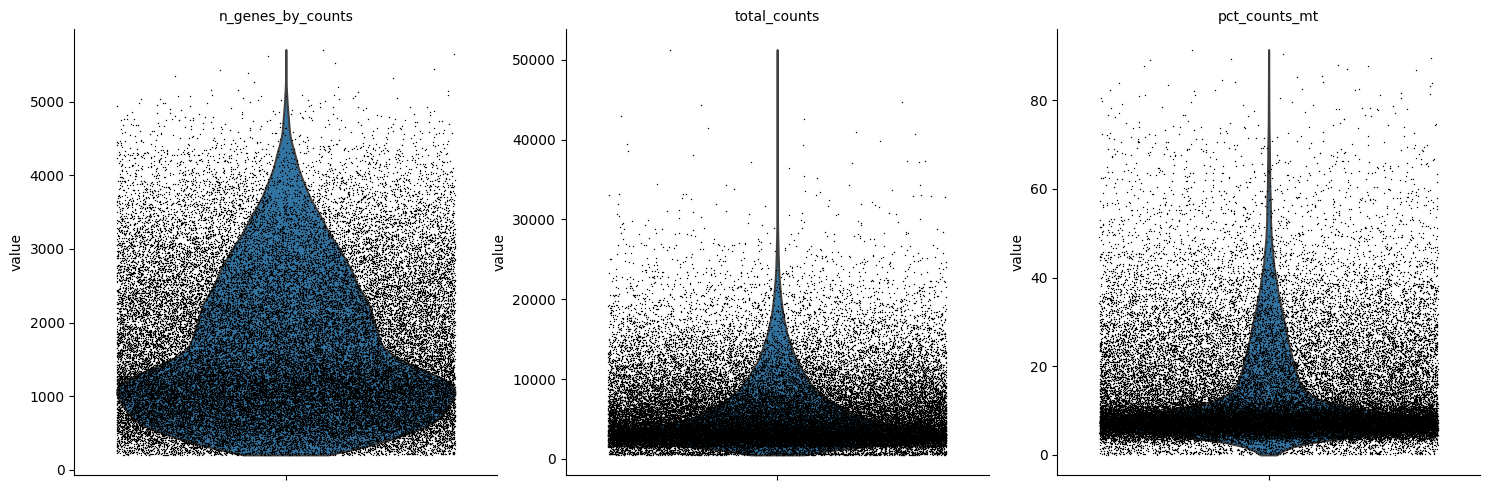

In [ ]:
# Quality control metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
# Violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

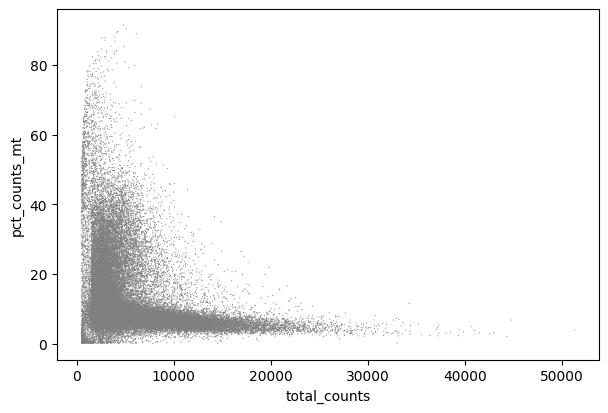

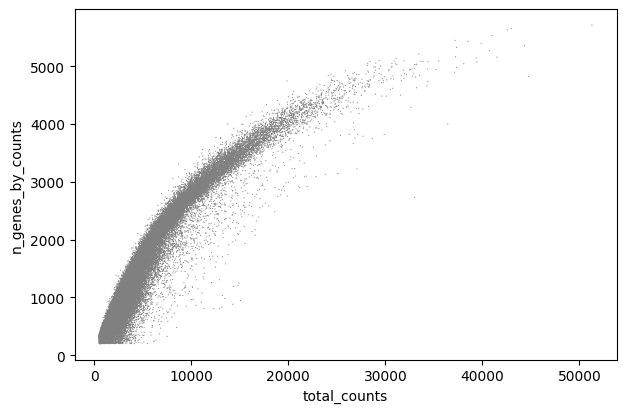

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
# Filtering the data for further processing
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
adata = adata[adata.obs.n_genes_by_counts.values < upper_lim]
adata = adata[adata.obs.pct_counts_mt < 20]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 35925 × 19199
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [ ]:
adata.var

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
LOC107049475,1480,False,1480,0.032873,96.848986,1544.0
CLC2DL5,7253,False,7253,0.185441,84.557900,8710.0
LOC112532835,1932,False,1932,0.043603,95.886649,2048.0
CLC2DL2,10078,False,10078,0.272456,78.543295,12797.0
CLC2DL4,4517,False,4517,0.114331,90.383019,5370.0
...,...,...,...,...,...,...
ND5,46183,True,46183,28.401989,1.673444,1334013.0
CYTB,46337,True,46337,39.080009,1.345568,1835549.0
ND6,44648,True,44648,10.951883,4.941557,514399.0
BC6_85_A,349,False,349,0.012391,99.256957,582.0


In [ ]:
adata.obs

,Sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCCAAGCTATCTG-1,S1,1019,1019,2483.0,203.0,8.175594
AAACCCAAGGATTCAA-1,S1,1889,1889,5971.0,637.0,10.668230
AAACCCAAGGTTGGAC-1,S1,1334,1334,3499.0,446.0,12.746499
AAACCCACAGACCTGC-1,S1,1953,1953,6526.0,764.0,11.707018
AAACCCACAGTCAGCC-1,S1,2021,2021,6223.0,556.0,8.934598
...,...,...,...,...,...,...
TTTGTTGAGGAGGTTC-1,S4,1135,1135,3301.0,285.0,8.633748
TTTGTTGAGTGTTGAA-1,S4,1452,1452,6958.0,412.0,5.921242
TTTGTTGAGTTTGTCG-1,S4,783,783,3517.0,291.0,8.274097
TTTGTTGCATAAGCAA-1,S4,1663,1663,7600.0,1256.0,16.526316


In [ ]:
# Cells in each sample
adata.obs.groupby('Sample').count()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
Sample,,,,,
S1,12908,12908,12908,12908,12908
S2,5824,5824,5824,5824,5824
S3,13879,13879,13879,13879,13879
S4,3314,3314,3314,3314,3314


### Normalization

In [ ]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)
# Log counts
sc.pp.log1p(adata)
# Saving the raw data
adata.raw = adata

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Saving the adata file after normalization
adata.write_h5ad('combined.h5ad')

### Feature selection

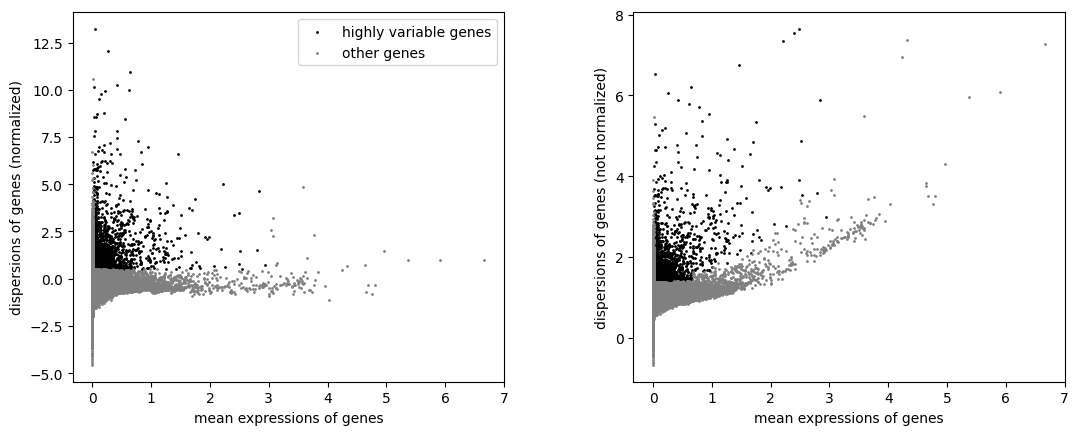

In [ ]:
# Highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

### Dimentionality Reduction

In [ ]:
# Scaling the data
sc.pp.scale(adata, max_value = 10)

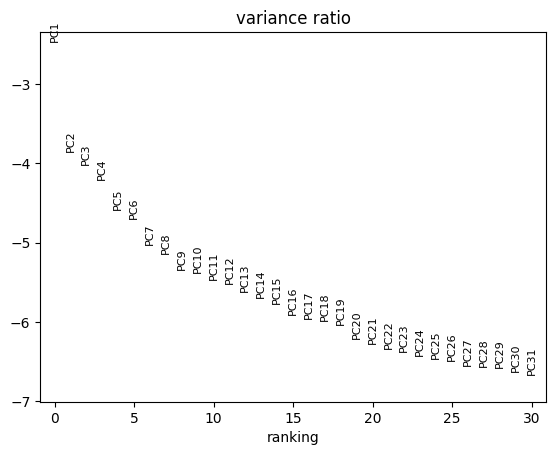

In [ ]:
# Calculating PCA
sc.tl.pca(adata, svd_solver='arpack')
# Plotting PCA
sc.pl.pca_variance_ratio(adata, log=True)

### Compute the neighborhoods

In [ ]:
# Finding neighborhoods
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.25)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


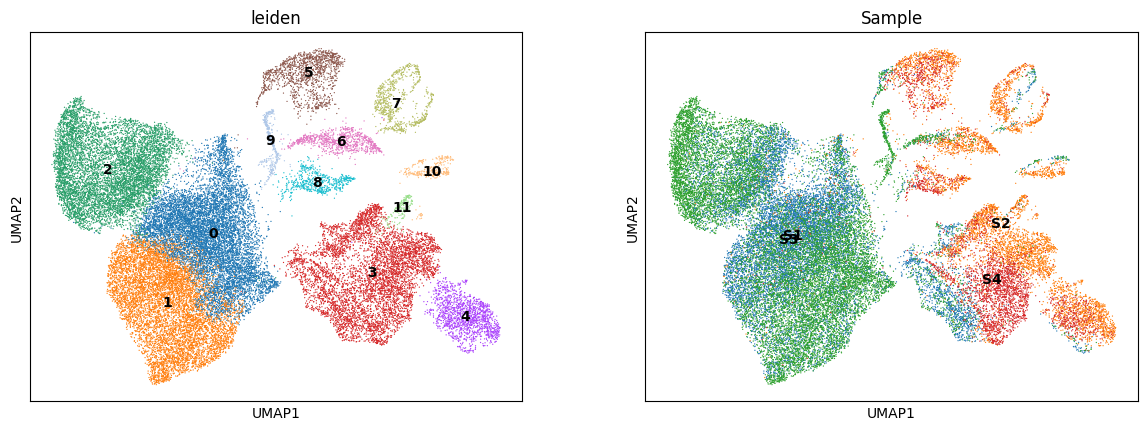

In [ ]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], legend_loc='on data')

In [ ]:
adata

AnnData object with n_obs × n_vars = 35925 × 19199
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Integration

In [ ]:
# Reading the file saved after Normalization
adata = sc.read_h5ad('combined.h5ad')

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata

AnnData object with n_obs × n_vars = 35925 × 19199
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

Feature Selection

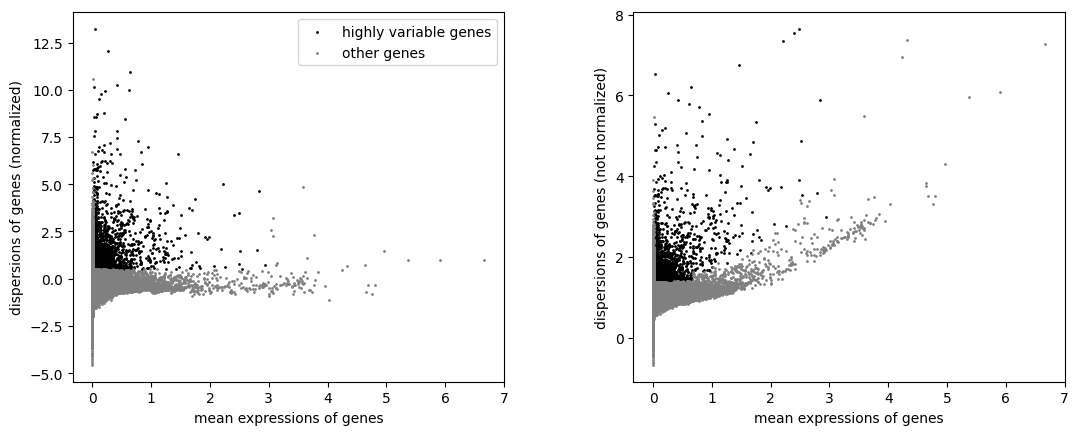

In [ ]:
# Highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [ ]:
# Scaling the data
sc.pp.scale(adata, max_value=10)

Dimentionality reduction

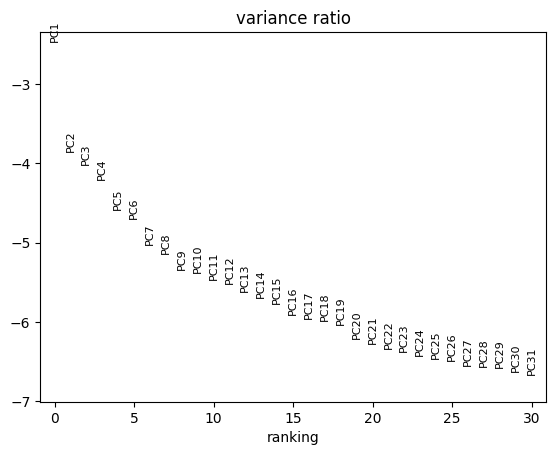

In [ ]:
# Calculating PCA
sc.tl.pca(adata, svd_solver='arpack')
# Plotting PCA
sc.pl.pca_variance_ratio(adata, log=True)

Batch effect removal and integration

In [ ]:
!pip install bbknn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552450 sha256=1d6cd1f71e946b01722fdfdca981e30ed2d14f1f6185d4b84a9c4e81e91f1fff
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
import bbknn
# Finding neighborhoods
sc.external.pp.bbknn(adata, batch_key = 'Sample')

### Clustering

In [ ]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


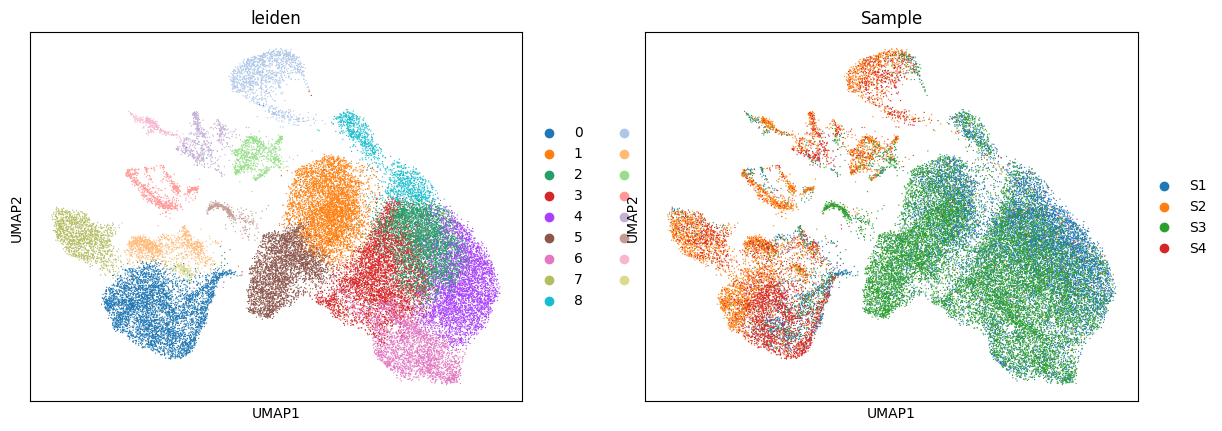

In [ ]:
sc.pl.umap(adata, color = ['leiden', 'Sample'])

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


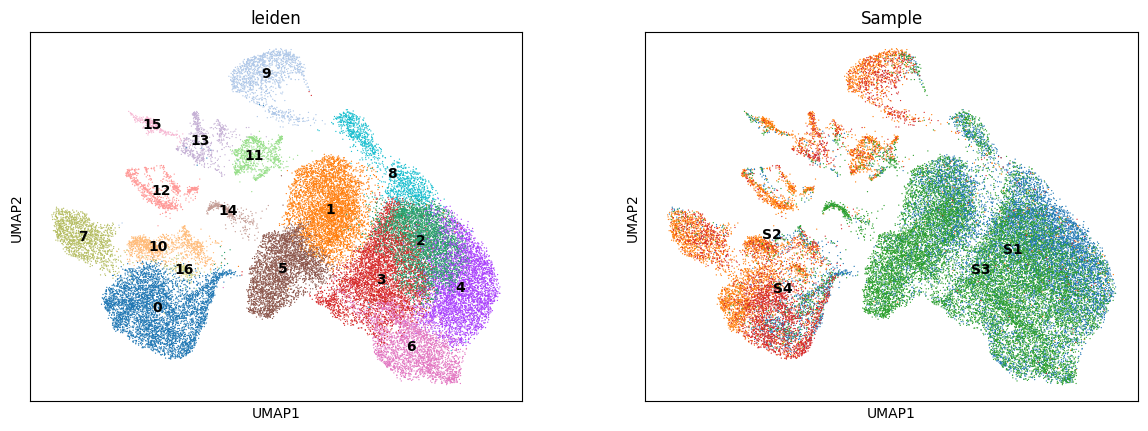

In [ ]:
sc.pl.umap(adata, color = ['leiden', 'Sample'], legend_loc='on data')

In [ ]:
adata.write_h5ad('integrated.h5ad')

### Finding markers

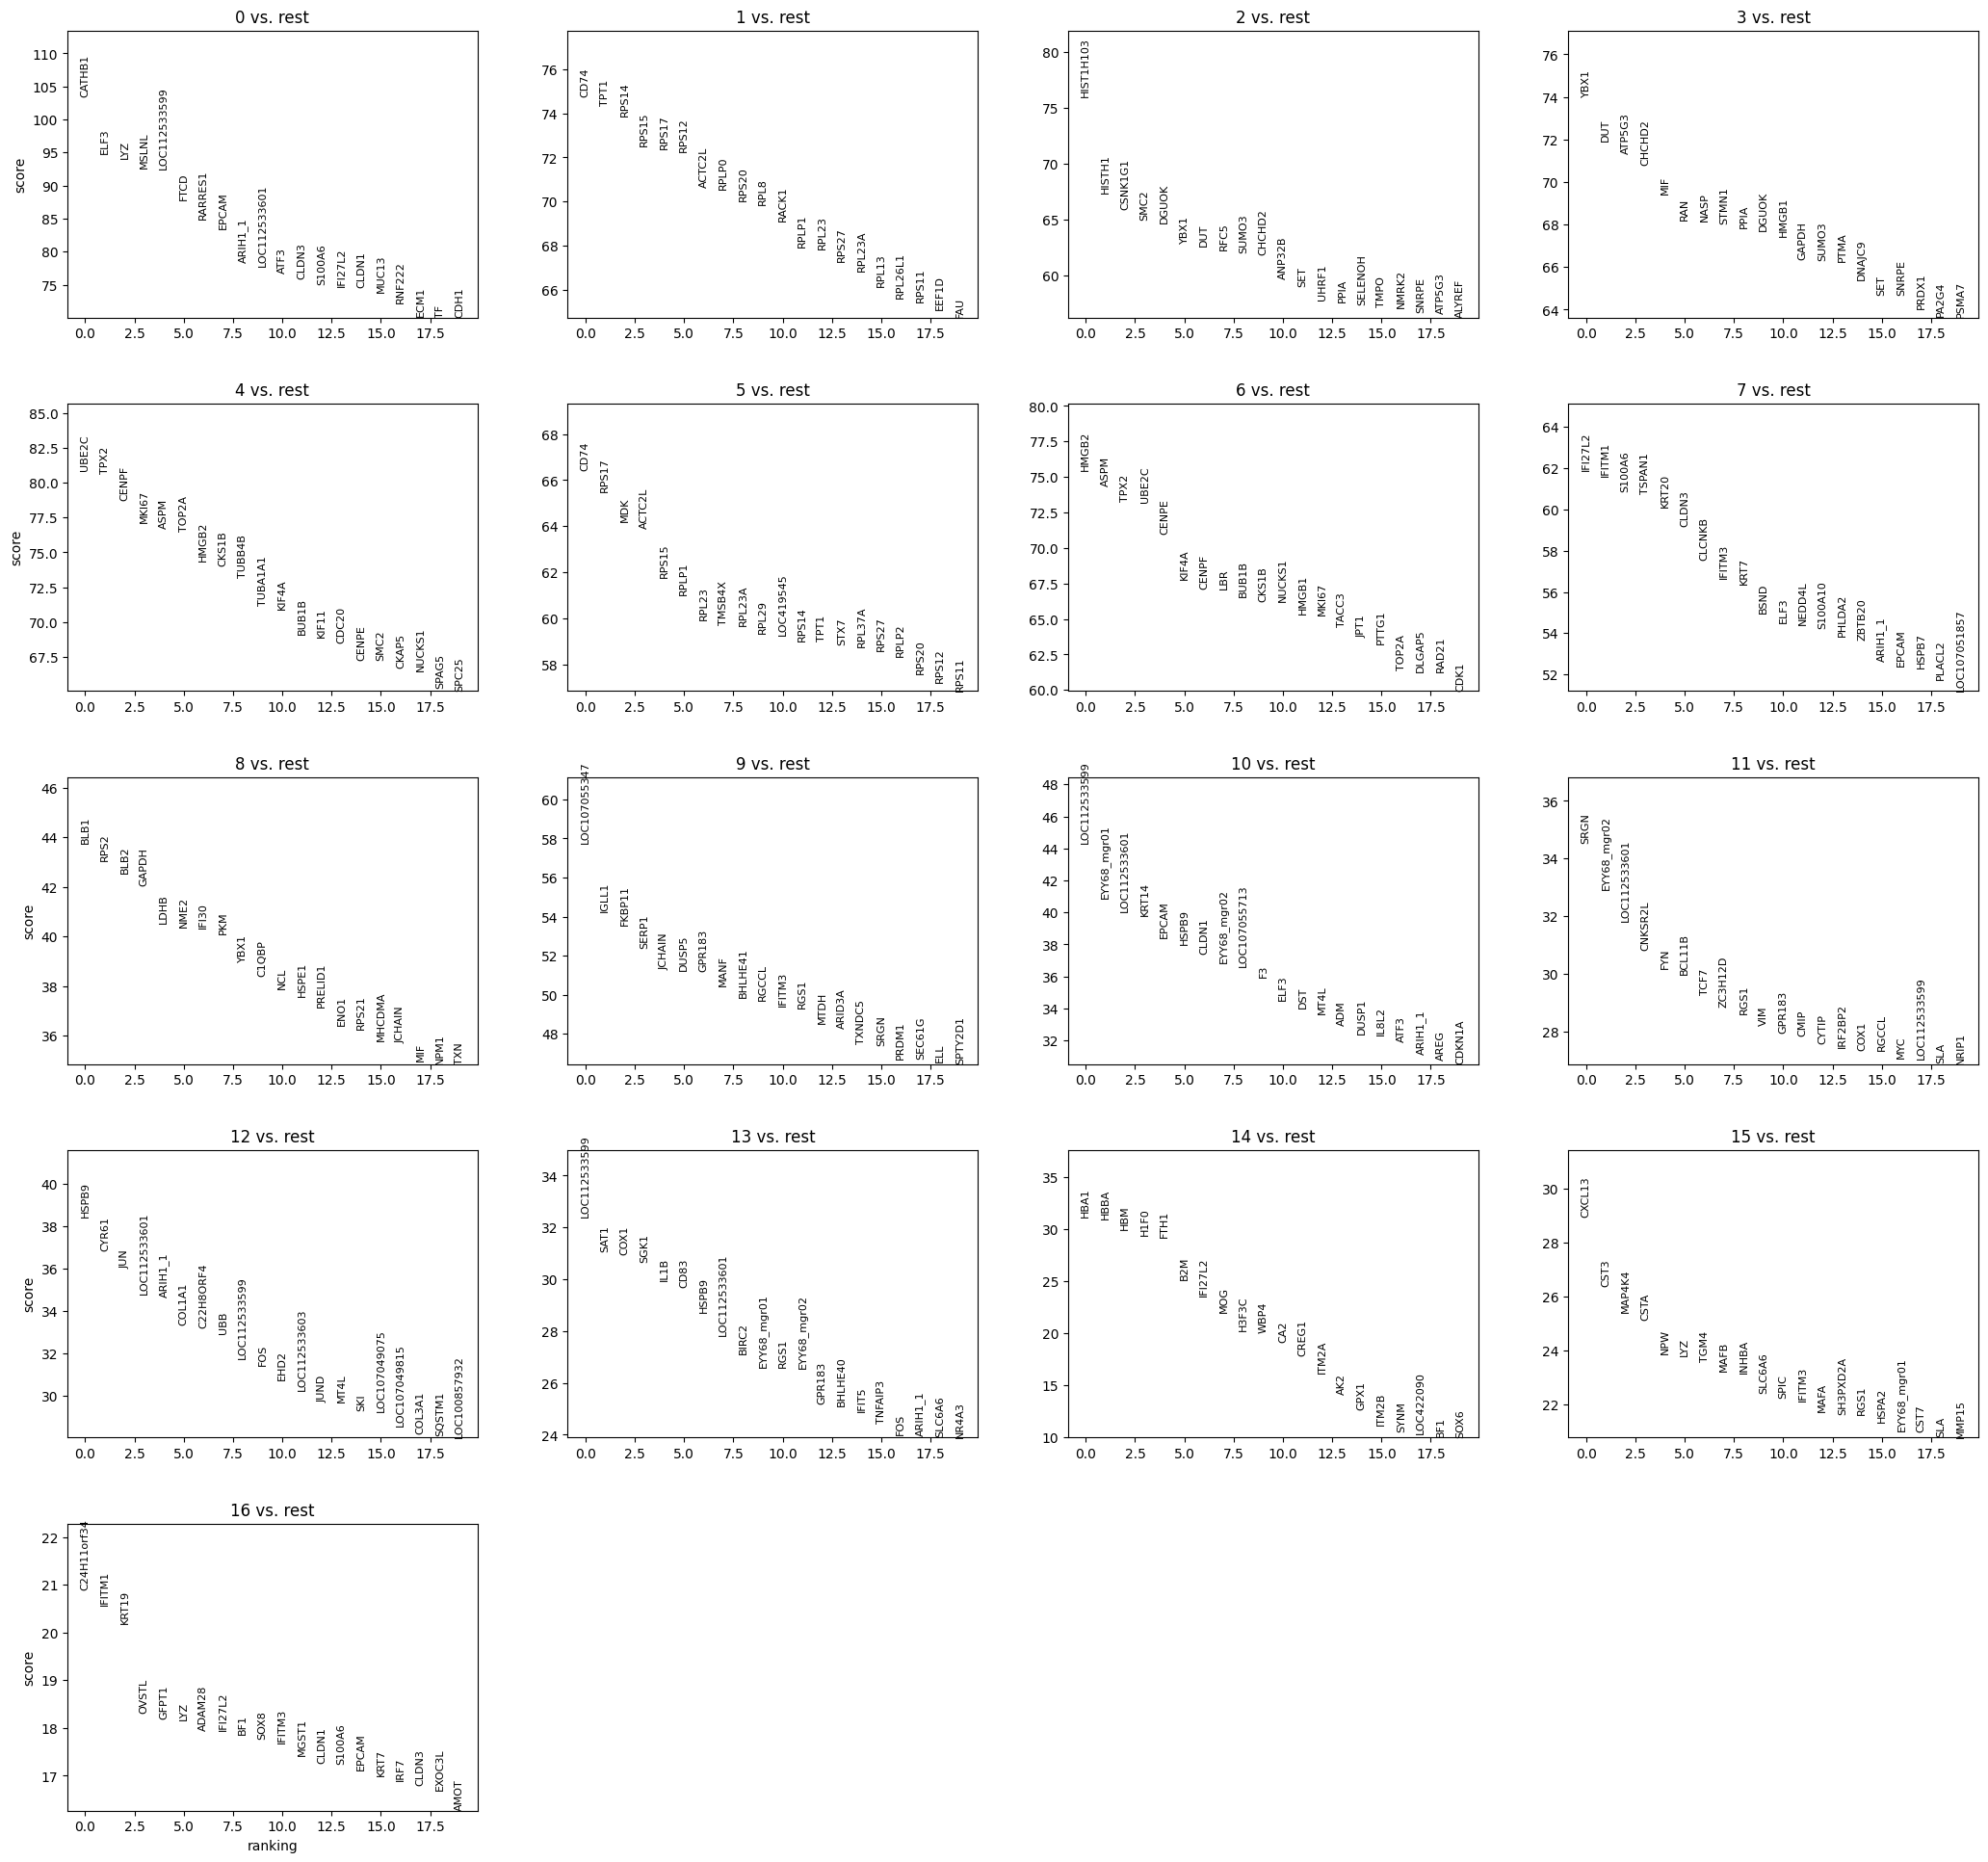

In [ ]:
# Finding markers
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [ ]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,CATHB1,103.430763,6.786767,0.000000,0.000000
1,0,ELF3,94.782181,5.774879,0.000000,0.000000
2,0,LYZ,94.157242,6.023331,0.000000,0.000000
3,0,MSLNL,92.671005,7.490465,0.000000,0.000000
4,0,LOC112533599,92.478691,2.434439,0.000000,0.000000
...,...,...,...,...,...,...
308549,16,ZHX1,2.603801,1.345640,0.009220,0.049090
308550,16,ASL2,2.601132,2.294388,0.009292,0.049429
308551,16,CC2D1B,2.599622,1.155627,0.009333,0.049634
308552,16,SIN3A,2.599072,1.387616,0.009348,0.049672


In [ ]:
# Saving the markers as dataframe
marker_genes_all = pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(10)
marker_genes_all

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,CATHB1,CD74,HIST1H103,YBX1,UBE2C,CD74,HMGB2,IFI27L2,BLB1,LOC107055347,LOC112533599,SRGN,HSPB9,LOC112533599,HBA1,CXCL13,C24H11orf34
1,ELF3,TPT1,HISTH1,DUT,TPX2,RPS17,ASPM,IFITM1,RPS2,IGLL1,EYY68_mgr01,EYY68_mgr02,CYR61,SAT1,HBBA,CST3,IFITM1
2,LYZ,RPS14,CSNK1G1,ATP5G3,CENPF,MDK,TPX2,S100A6,BLB2,FKBP11,LOC112533601,LOC112533601,JUN,COX1,HBM,MAP4K4,KRT19
3,MSLNL,RPS15,SMC2,CHCHD2,MKI67,ACTC2L,UBE2C,TSPAN1,GAPDH,SERP1,KRT14,CNKSR2L,LOC112533601,SGK1,H1F0,CSTA,OVSTL
4,LOC112533599,RPS17,DGUOK,MIF,ASPM,RPS15,CENPE,KRT20,LDHB,JCHAIN,EPCAM,FYN,ARIH1_1,IL1B,FTH1,NPW,GFPT1
5,FTCD,RPS12,YBX1,RAN,TOP2A,RPLP1,KIF4A,CLDN3,NME2,DUSP5,HSPB9,BCL11B,COL1A1,CD83,B2M,LYZ,LYZ
6,RARRES1,ACTC2L,DUT,NASP,HMGB2,RPL23,CENPF,CLCNKB,IFI30,GPR183,CLDN1,TCF7,C22H8ORF4,HSPB9,IFI27L2,TGM4,ADAM28
7,EPCAM,RPLP0,RFC5,STMN1,CKS1B,TMSB4X,LBR,IFITM3,PKM,MANF,EYY68_mgr02,ZC3H12D,UBB,LOC112533601,MOG,MAFB,IFI27L2
8,ARIH1_1,RPS20,SUMO3,PPIA,TUBB4B,RPL23A,BUB1B,KRT7,YBX1,BHLHE41,LOC107055713,RGS1,LOC112533599,BIRC2,H3F3C,INHBA,BF1
9,LOC112533601,RPL8,CHCHD2,DGUOK,TUBA1A1,RPL29,CKS1B,BSND,C1QBP,RGCCL,F3,VIM,FOS,EYY68_mgr01,WBP4,SLC6A6,SOX8


In [ ]:
adata.uns['markers'] = markers
adata

AnnData object with n_obs × n_vars = 35925 × 19199
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'Cell Type', 'Condition', 'Control', 'Infected'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors', 'rank_genes_groups', 'Cell Type_colors', 'Condition_colors', 'Control_colors', 'Infected_colors', 'markers'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Labelling Cell types

In [ ]:
cell_type = {"0":"Macrophages",
"1":"B cells",
"2":"B cells",
"3":"Macrophages",
"4":"B cells",
"5":"B cells",
"6":"B cells",
"7":"Fibroblasts",
"8":"B cells",
"9":"Dendritic cells",
"10":"Fibroblasts",
"11":"T cells",
"12":"Neutrophils",
"13":"Macrophages",
"14":"Epithelial cells",
"15":"Epithelial cells",
"16":"Epithelial cells",
 }

In [ ]:
adata.obs['Cell Type'] = adata.obs.leiden.map(cell_type)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


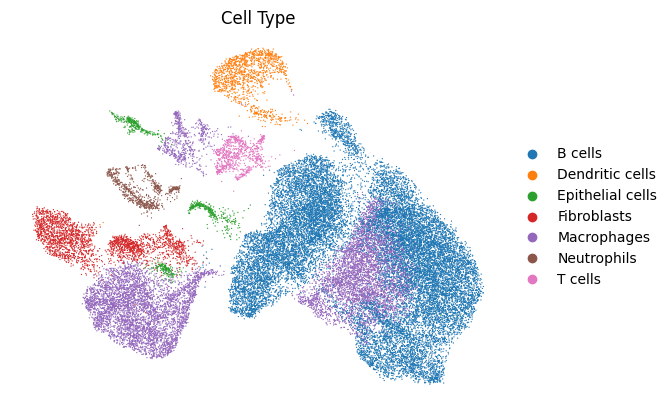

In [ ]:
sc.pl.umap(adata, color = ['Cell Type'], frameon=False)

### Cellular Diversity in Control and Infected samples

In [ ]:
condition = {"S1":"Control",
"S2":"Infected",
"S3":"Control",
"S4":"Infected",
 }
adata.obs['Condition'] = adata.obs.Sample.map(condition)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


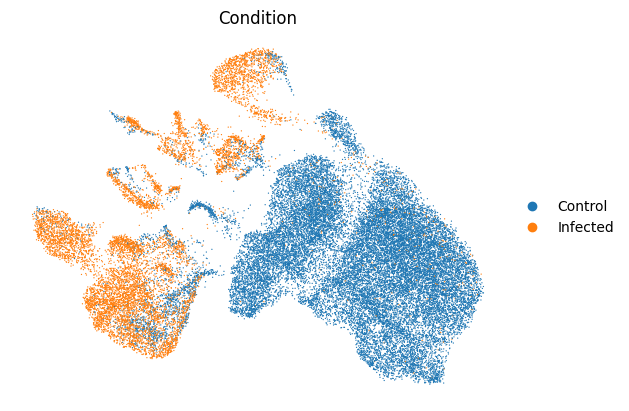

In [ ]:
sc.pl.umap(adata, color = ['Condition'], frameon=False)

In [ ]:
control = ["Control"]
adata1 = adata[adata.obs.Condition.isin(control)]

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


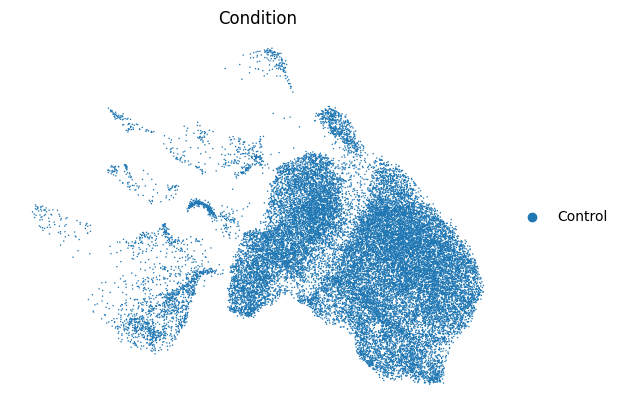

In [ ]:
sc.pl.umap(adata1, color = ['Condition'], frameon=False)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


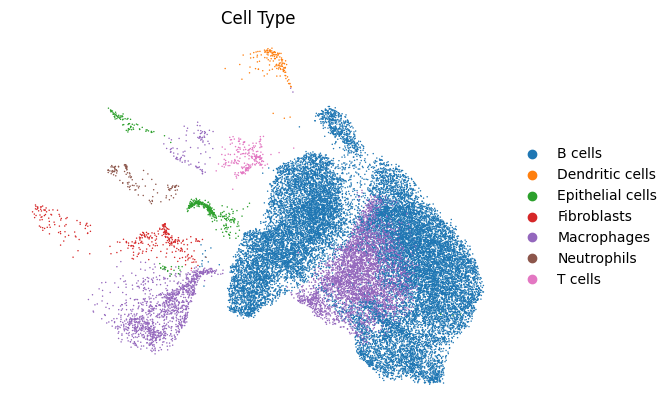

In [ ]:
sc.pl.umap(adata1, color = ['Cell Type'], frameon=False)

In [ ]:
control = ["Infected"]
adata2 = adata[adata.obs.Condition.isin(control)]

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


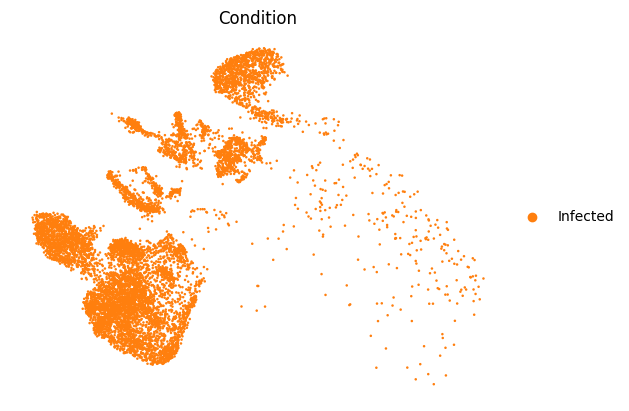

In [ ]:
sc.pl.umap(adata2, color = ['Condition'], frameon=False)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


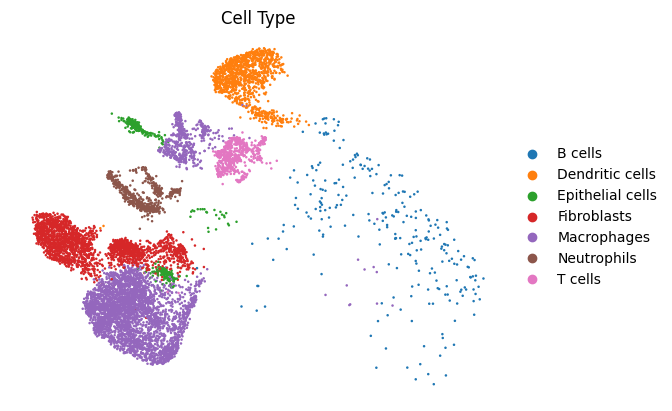

In [ ]:
sc.pl.umap(adata2, color = ['Cell Type'], frameon=False)